In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

Data Processing

In [ ]:
# Load the sales data
file_path = 'sales_data.csv'# Update with your file path
sales_data = pd.read_csv(file_path)


# Convert 'Month' and 'Year' columns into a proper date format
sales_data['Date'] = pd.to_datetime(sales_data['Month'] + ' ' + sales_data['Year'].astype(str), format='%b %Y')

# Drop the original 'Month' and 'Year' columns
sales_data.drop(['Month', 'Year'], axis=1, inplace=True)

# Remove all non-numeric characters from 'Actual Amount' and 'Stat Forecast' and convert to numeric
sales_data['Actual Amount'] = sales_data['Actual Amount'].str.replace(r'[^0-9.]', '', regex=True).replace('', np.nan).astype(float)
sales_data['Stat Forecast'] = sales_data['Stat Forecast'].str.replace(r'[^0-9.]', '', regex=True).replace('', np.nan).astype(float)

# Save the preprocessed data to a new CSV file
processed_file_path = 'processed_sales_data.csv'
sales_data.to_csv(processed_file_path, index=False)

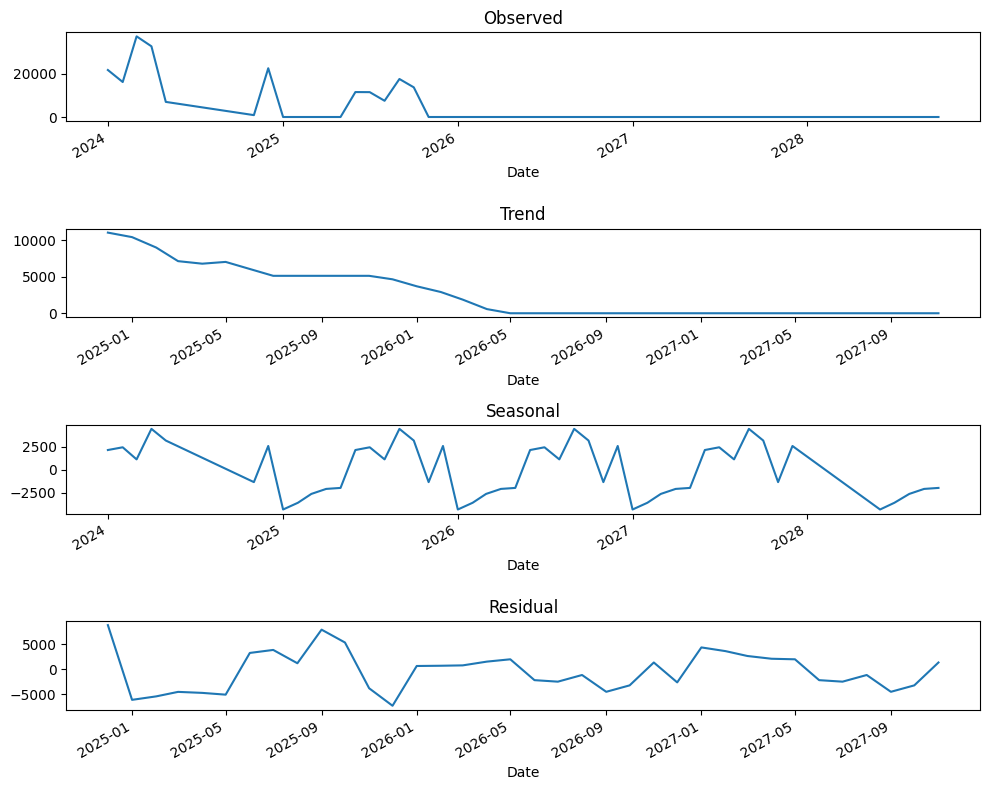

In [27]:
# Aggregate the data by 'Item Description' and 'Date'
aggregated_data = sales_data.groupby(['Item Description', 'Date']).agg({
    'Stat Forecast': 'sum',
    'Actual Amount': 'sum'
}).reset_index()

# Select a product with sufficient data for time series analysis
product_data = aggregated_data[aggregated_data['Item Description'] == 'Item AAO']

# Set the 'Date' column as the index for time series analysis
product_data.set_index('Date', inplace=True)

# Perform time series decomposition on the 'Actual Amount'
decomposition = seasonal_decompose(product_data['Actual Amount'], model='additive', period=12)

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
decomposition.observed.plot(ax=ax1, title='Observed')
decomposition.trend.plot(ax=ax2, title='Trend')
decomposition.seasonal.plot(ax=ax3, title='Seasonal')
decomposition.resid.plot(ax=ax4, title='Residual')
plt.tight_layout()
plt.show()

In [28]:
# Load the uploaded CSV file
file_path = 'preprocessed_sales_data.csv'
data = pd.read_csv(file_path)

# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Ensure numeric conversion for 'Stat Forecast' and 'Actual Amount'
data['Stat Forecast'] = pd.to_numeric(data['Stat Forecast'], errors='coerce').fillna(0)
data['Actual Amount'] = pd.to_numeric(data['Actual Amount'], errors='coerce').fillna(0)

# Drop rows with invalid dates
data = data[data['Date'].notnull()]

# Calculate the deviation between 'Stat Forecast' and 'Actual Amount'
data['Deviation'] = data['Stat Forecast'] - data['Actual Amount']

# Classify the deviations into categories: 'High', 'Medium', 'Low'
# Assuming thresholds for classification: High (> 10000), Medium (1000 to 10000), Low (< 1000)
data['Deviation Category'] = pd.cut(
    data['Deviation'].abs(),
    bins=[0, 1000, 10000, float('inf')],
    labels=['Low', 'Medium', 'High'],
    include_lowest=True
)

# Fill missing values in 'Deviation Category' (if any)
data['Deviation Category'] = data['Deviation Category'].fillna('Low')

# Assign priority: High -> 1, Medium -> 2, Low -> 3
data['Priority'] = data['Deviation Category'].map({'High': 1, 'Medium': 2, 'Low': 3}).fillna(3)

# Sort data by priority and deviation
priority_data = data.sort_values(by=['Priority', 'Deviation'], ascending=[True, False])

# Save the priority data to a CSV file
priority_data_path = 'priority_data_fixed.csv'
priority_data.to_csv(priority_data_path, index=False)





In [29]:
# Display the deviation counts and the first few rows of the priority data
deviation_counts = data['Deviation Category'].value_counts()
print("Deviation Counts:\n", deviation_counts)
print("\nPriority Data (First 5 Rows):\n", priority_data.head())


Deviation Counts:
 Deviation Category
High      3395
Medium    1275
Low       1089
Name: count, dtype: int64

Priority Data (First 5 Rows):
      Business Unit          PH1           PH2  Item Code Item Description  \
4576           BU1   Category 6   Category 6G     530355         Item AXK   
4577           BU1   Category 6   Category 6G     530355         Item AXK   
4578           BU1   Category 6   Category 6G     530355         Item AXK   
371            BU1  Category 11  Category 11G     651592         Item YLW   
372            BU1  Category 11  Category 11G     651592         Item YLW   

     Sales Channel  Stat Forecast  Actual Amount       Date  Deviation  \
4576     Channel_X          989.0            0.0 2028-07-01      989.0   
4577     Channel_X          989.0            0.0 2026-07-01      989.0   
4578     Channel_X          989.0            0.0 2027-07-01      989.0   
371      Channel_X          979.0            0.0 2026-01-01      979.0   
372      Channel_X        